In [1]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import logging

In [2]:
from pandas import IndexSlice as idx

In [3]:
from backtesting import perform_backtest, PortfolioBacktest
from sharpe import calc_sharpe

from vfinx_vs_vix_strategy import VIXCounteringStrategyBacktest

In [4]:
source_folder = 'files'

# Constants

In [5]:
capital = 1e6
lower_freq = 5

# Reading data

## VFINX

In [6]:
with open(f'{source_folder}/VFINX.json', 'r') as file:
    _vfinx = json.load(file)

vfinx = pd.DataFrame.from_dict(_vfinx).copy()
vfinx.index = pd.Series(pd.to_numeric(vfinx.index)).apply(lambda _date: datetime.fromtimestamp(_date * 1e-3))
vfinx.sort_index(ascending=True, inplace=True)

vfinx.index = vfinx.index.tz_localize(None).floor(freq='D')

vfinx.sort_index(ascending=True, inplace=True)

In [7]:
vfinx.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,VIX_Close
count,8833.000000,8833.000000,8833.000000,8833.000000,8833.0,8833.000000,8833.0,8833.000000
mean,91.410905,91.410905,91.410905,91.410905,0.0,0.008916,0.0,19.925365
std,74.364430,74.364430,74.364430,74.364430,0.0,0.081741,0.0,8.501164
min,9.693998,9.693998,9.693998,9.693998,0.0,0.000000,0.0,9.140000
25%,26.499744,26.499744,26.499744,26.499744,0.0,0.000000,0.0,14.090000
50%,77.715508,77.715508,77.715508,77.715508,0.0,0.000000,0.0,18.130000
75%,107.777855,107.777855,107.777855,107.777855,0.0,0.000000,0.0,23.250000
max,355.809998,355.809998,355.809998,355.809998,0.0,1.390000,0.0,150.190000


In [8]:
vfinx['Volume'].value_counts()

0    8833
Name: Volume, dtype: int64

In [9]:
vfinx['Dividends'].value_counts()

0.000    8692
0.180      15
0.220      12
0.350       5
0.300       5
         ... 
0.520       1
0.480       1
0.490       1
0.530       1
1.311       1
Name: Dividends, Length: 91, dtype: int64

In [10]:
vfinx['Stock Splits'].value_counts()

0    8833
Name: Stock Splits, dtype: int64

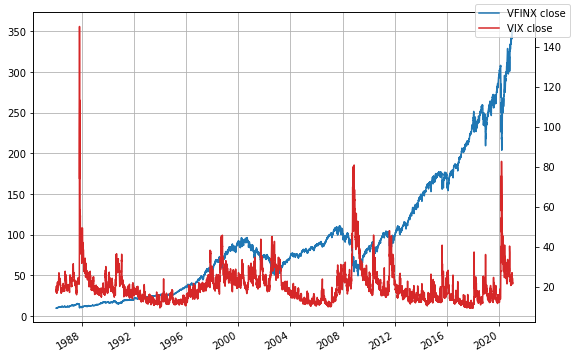

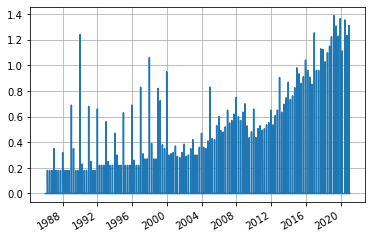

In [11]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()

vfinx['Close'].plot(ax=ax1, label='VFINX close')
vfinx['VIX_Close'].plot(ax=ax2, label='VIX close', color='tab:red')

fig.legend()
ax1.grid()
# ax2.grid()
fig.tight_layout()
plt.show()

vfinx['Dividends'].plot()
plt.grid()
plt.show()

In [12]:
vfinx

,Open,High,Low,Close,Volume,Dividends,Stock Splits,VIX_Close
1986-01-02,9.969467,9.969467,9.969467,9.969467,0,0.0,0,18.07
1986-01-03,10.035052,10.035052,10.035052,10.035052,0,0.0,0,17.96
1986-01-06,10.030688,10.030688,10.030688,10.030688,0,0.0,0,17.05
1986-01-07,10.179354,10.179354,10.179354,10.179354,0,0.0,0,17.39
1986-01-08,9.899508,9.899508,9.899508,9.899508,0,0.0,0,19.97
...,...,...,...,...,...,...,...,...
2021-01-15,347.940002,347.940002,347.940002,347.940002,0,0.0,0,24.34
2021-01-19,350.779999,350.779999,350.779999,350.779999,0,0.0,0,23.24
2021-01-20,355.670013,355.670013,355.670013,355.670013,0,0.0,0,21.58
2021-01-21,355.809998,355.809998,355.809998,355.809998,0,0.0,0,21.32


## 10Y US Notes

In [13]:
ust = pd.read_csv('files/ust_10y_yields_hist.csv')
ust['Date'] = pd.to_datetime(ust['Date'])
ust.set_index('Date', inplace=True)
ust.sort_index(ascending=True, inplace=True)

In [14]:
ust['Close'].describe()

count    9061.000000
mean        4.727160
std         2.321428
min         0.499000
25%         2.624000
50%         4.564000
75%         6.537000
max        10.230000
Name: Close, dtype: float64

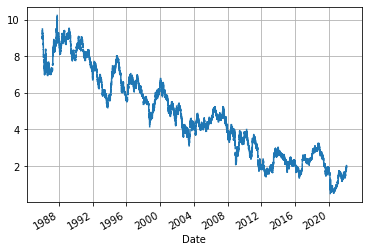

In [15]:
ust['Close'].plot()

plt.grid()
plt.show()

# Setting some params

In [16]:
dates = vfinx.index
securities = ['VFINX']
max_loan = 0

quotes = vfinx[['Close']].copy()
quotes.columns = securities

cashflows = pd.DataFrame(vfinx['Dividends'].rename(securities[0])).copy()

# Countering VIX strategy

In [17]:
ini_positions = None

my_strat_backtest = VIXCounteringStrategyBacktest(securities=securities,
                                                  dates=dates,
                                                  quotes=quotes,
                                                  cashflows=cashflows,
                                                  capital=capital,
                                                  ini_positions=ini_positions,
                                                  max_loan=max_loan,
                                                  lower_freq=lower_freq)

In [18]:
vix = vfinx['VIX_Close'].copy()
opens = vfinx['Open'].copy()

In [19]:
logging.basicConfig(level=logging.DEBUG, filename='task_1.log')

In [20]:
(pd.Timestamp('2022-02-05') - pd.Timestamp('2022-02-01')).days

4

In [21]:
vix.describe()

count    8833.000000
mean       19.925365
std         8.501164
min         9.140000
25%        14.090000
50%        18.130000
75%        23.250000
max       150.190000
Name: VIX_Close, dtype: float64

In [22]:
def calc_alloc(vix, threshs: list):
    if vix < threshs[0]:
        alloc = 1
    elif threshs[0] <= vix < threshs[1]:
        alloc = .5
    else:
        alloc = .25
    
    return alloc

# kwargs = {'thresh_1': 20, 'thresh_2': 23, 'thresh_3': 50}
kwargs = {'threshs': [20, 24]}

In [23]:
%%time

my_strat_backtest.run_strategy(vix=vix, calc_alloc=calc_alloc, opens=opens, **kwargs)

CPU times: user 1min 1s, sys: 1.92 s, total: 1min 3s
Wall time: 1min 5s


In [24]:
portfolio_ms = my_strat_backtest.get_combined_df()

In [25]:
portfolio_ms['nav'].iloc[-1] * 1e-6

13.269366168191015

In [26]:
portfolio_ms

attr             price      cashflow         weight                       #  \
sec              VFINX cash    VFINX cash     VFINX      cash         VFINX   
1986-01-02    9.969467    1      0.0    0  0.000000  1.000000      0.000000   
1986-01-03   10.035052    1      0.0    0  0.000000  1.000000      0.000000   
1986-01-06   10.030688    1      0.0    0  0.999565  0.000435  99650.701377   
1986-01-07   10.179354    1      0.0    0  0.999571  0.000429  99650.701377   
1986-01-08    9.899508    1      0.0    0  0.999559  0.000441  99650.701377   
...                ...  ...      ...  ...       ...       ...           ...   
2021-01-15  347.940002    1      0.0    0  0.496328  0.503672  18798.786246   
2021-01-19  350.779999    1      0.0    0  0.251024  0.748976   9468.931929   
2021-01-20  355.670013    1      0.0    0  0.253635  0.746365   9468.931929   
2021-01-21  355.809998    1      0.0    0  0.253710  0.746290   9468.931929   
2021-01-22  354.739990    1      0.0    0  0.253140  0.746860   9468.931929   

attr                             value                   rebalance  \
sec                 cash         VFINX          cash         VFINX   
1986-01-02  1.000000e+06  0.000000e+00  1.000000e+06           NaN   
1986-01-03  1.000000e+06  0.000000e+00  1.000000e+06           NaN   
1986-01-06  4.348770e+02  9.995651e+05  4.348770e+02  99650.701377   
1986-01-07  4.348770e+02  1.014380e+06  4.348770e+02           NaN   
1986-01-08  4.348770e+02  9.864929e+05  4.348770e+02           NaN   
...                  ...           ...           ...           ...   
2021-01-15  6.637631e+06  6.540850e+06  6.637631e+06           NaN   
2021-01-19  9.910357e+06  3.321512e+06  9.910357e+06  -9329.854317   
2021-01-20  9.910357e+06  3.367815e+06  9.910357e+06           NaN   
2021-01-21  9.910357e+06  3.369141e+06  9.910357e+06           NaN   
2021-01-22  9.910357e+06  3.359009e+06  9.910357e+06           NaN   

attr                     rebalance price                nav  
sec                 cash           VFINX cash                
1986-01-02           NaN             NaN    1  1.000000e+06  
1986-01-03           NaN             NaN    1  1.000000e+06  
1986-01-06 -9.995651e+05       10.030688    1  1.000000e+06  
1986-01-07           NaN             NaN    1  1.014815e+06  
1986-01-08           NaN             NaN    1  9.869277e+05  
...                  ...             ...  ...           ...  
2021-01-15           NaN             NaN    1  1.317848e+07  
2021-01-19  3.272726e+06      350.779999    1  1.323187e+07  
2021-01-20           NaN             NaN    1  1.327817e+07  
2021-01-21           NaN             NaN    1  1.327950e+07  
2021-01-22           NaN             NaN    1  1.326937e+07  

[8833 rows x 15 columns]

In [28]:
# pd.concat([portfolio_ms, pd.DataFrame(vix)], axis='columns', join='outer').head(10)

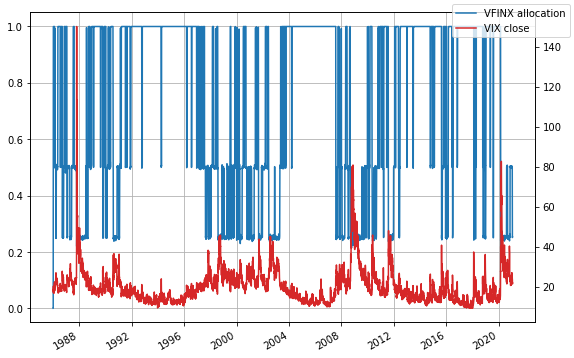

In [29]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()

portfolio_ms['weight']['VFINX'].plot(ax=ax1, label='VFINX allocation')
vix.plot(ax=ax2, label='VIX close', color='tab:red')

fig.legend()
ax1.grid()
# ax2.grid()
fig.tight_layout()
plt.show()

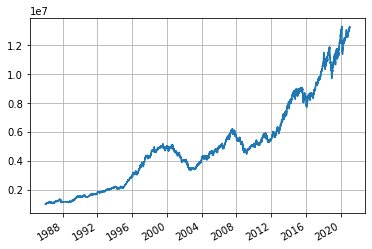

In [30]:
portfolio_ms['nav'].plot()

plt.grid()
plt.show()

## Evaluating aggregate portfolio results

In [31]:
annualization_factor = 360

portf_res_ms = perform_backtest(my_strat_backtest.nav, ust['Close'] / 100, risk_free_annualized=True,
                                annualization_factor=annualization_factor).copy()

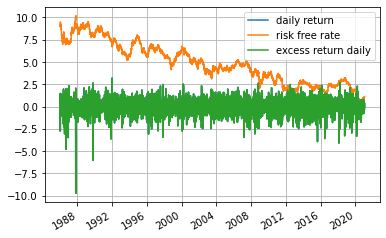

In [32]:
_cols = ['daily return', 'risk free rate', 'excess return daily']
_data = portf_res_ms[_cols] * 100
_data.plot()

plt.grid()
plt.show()

### Return

In [33]:
(portf_res_ms['total return'].iloc[-1] + 1) ** (1 / 35) - 1

0.07666707835674624

### Sharpe

In [34]:
calc_sharpe(portf_res_ms['excess return'].mean(),
            portf_res_ms['excess return'].std(),
            multiply_by=252 ** .5)

0.5599452320145017

# Buy & hodl strategy

## Running strategy

In [35]:
# logging.basicConfig(level=logging.DEBUG)

In [36]:
ini_positions = None

pb = PortfolioBacktest(securities=securities,
                       dates=dates,
                       quotes=quotes,
                       capital=capital,
                       ini_positions=ini_positions,
                       max_loan=max_loan)

In [37]:
%%time

pb.run_strategy()

CPU times: user 15.3 s, sys: 394 ms, total: 15.7 s
Wall time: 16 s


In [38]:
portfolio_bh = pb.get_combined_df()

In [39]:
portfolio_bh['nav'].iloc[-1] * 1e-6

35.582642926735296

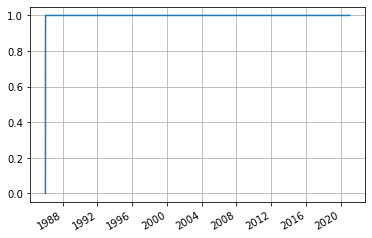

In [40]:
portfolio_bh['weight']['VFINX'].plot()

plt.grid()
plt.show()

## Evaluating aggregate portfolio results

In [41]:
annualization_factor = 360

portf_res_bh = perform_backtest(pb.nav, ust['Close'] / 100, risk_free_annualized=True,
                             annualization_factor=annualization_factor).copy()

In [42]:
(portf_res_bh['total return'].iloc[-1] + 1) ** (1 / 35) - 1

0.10744225828819354

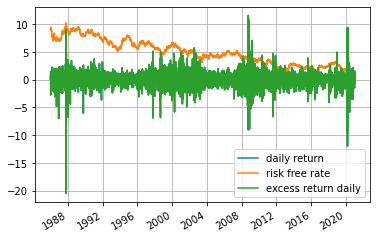

In [43]:
_cols = ['daily return', 'risk free rate', 'excess return daily']
_data = portf_res_bh[_cols] * 100
_data.plot()

plt.grid()
plt.show()

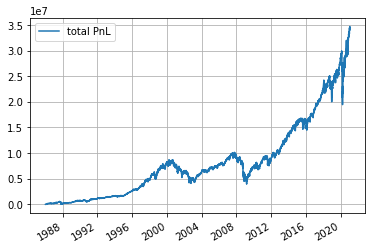

In [44]:
_cols = ['total PnL']
_data = portf_res_bh[_cols]
_data.plot()

plt.grid()
plt.show()

### Sharpe

In [45]:
calc_sharpe(portf_res_bh['excess return'].mean(),
            portf_res_bh['excess return'].std(),
            multiply_by=252 ** .5)

0.1828539744781804